# Introduction
The properties of lunar craters can provide insight into planetary formation, surface dating, and the properties of their incident projectiles (Ivanov et al. 2002). Notably, crater chronometry systems such as isochrons have been particularly useful in dating geological surfaces with size frequency distributions (SFD) of meteor diameters on Mars and the Moon (Hartmann 1999; Williams et al. 2014). 

In this work, we will model the size frequency distribution of lunar craters using Monte Carlo simulations and known asteroid SFDs. We draw upon research from other authors to understand lunar crater SFD (Cross 1966; Ivanov et al. 2002; Wilhelms et al. 1978), impact crater scaling laws based on asteroid properties (Holsapple 1987; Schmidt 1980; Wheeler & Mathias 2019), and apply Monte Carlo simulations to asteroids (Williams et al. 2014). We aim to derive results consistent with the lunar production function and modern crater catalogs. In particular, we will compare our simulated SFDs against the updated, uncertainty-aware lunar production function emerging from Robbins (2018), which leverages a nearly global, ≥1-km crater database to reconcile differences between the Hartmann and Neukum chronologies in the critical 0.5–50 km range (Robbins 2018). 

# Methods



In [1]:
import numpy as np
from random import choices
from matplotlib import pyplot as plt
import pandas as pd

def r_plot_prediction(diameter_list, coefficient_list):
    asteroid_count_list = []
    for d in diameter_list:
        log_d = np.log10(d)
        log_n = 0
        for i, coeff in enumerate(coefficient_list):
            log_n += coeff * (log_d ** i)
        n = 10 ** log_n
        asteroid_count_list.append(n)
    return asteroid_count_list

def generate_asteroid_population(diameter_list, normalized_asteroid_list, k = 100):
    new_population = choices(diameter_list, weights=normalized_asteroid_list, k=k)

    return new_population

def calculate_volume(simulated_asteroid_diameters_list):
    volume_list = []
    for d in simulated_asteroid_diameters_list:
        r = d / 2
        volume = (4/3) * np.pi * (r ** 3)
        volume_list.append(volume)
    return volume_list

def calculate_mass(volume_list):
    density = 2.7e12  # in kg/km^3
    mass_list = []
    for volume in volume_list:
        mass = density * volume
        mass_list.append(mass)
    return mass_list

def monte_carlo_simulation(diameter_list, normalized_asteroid_count_list, runs = 1000, k = 100):
    total_mass_list = []
    total_diameter_list = []
    total_volume_list = []
    for _ in range(runs):
        # get average volume, and diameters
        simulated_asteroid_diameters_list = generate_asteroid_population(diameter_list, normalized_asteroid_count_list, k)
        volume_list = calculate_volume(simulated_asteroid_diameters_list)
        mass_list = calculate_mass(volume_list)

        total_mass_list.append(mass_list)
        total_diameter_list.append(simulated_asteroid_diameters_list)
        total_volume_list.append(volume_list)

    return total_mass_list, total_diameter_list, total_volume_list 

def create_log_histogram(data, title, xlabel, ax):
    # Filter for positive values, as log scale cannot handle non-positives
    data_positive = data[data > 0]
    
    if len(data_positive) == 0:
        ax.set_title(title)
        ax.text(0.5, 0.5, "No positive data to plot.", transform=ax.transAxes, ha='center')
        return

    # Determine the range in log space
    min_val = data_positive.min()
    max_val = data_positive.max()
    
    # Create logarithmically spaced bins (100 bins for resolution)
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 100)
    
    # Plot the histogram
    # Density=False plots the raw count (frequency)
    ax.hist(data_positive, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
    
    # Set log scale for x-axis
    ax.set_xscale('log')
    
    # Set labels and title
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Frequency (Count)")
    ax.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.6)


In [18]:
# -----CONSTANTS------
MU_REGOLITH = 0.41 # μ from Holsapple paper's value for lunar regolith
RHO_IMP_G_CM3 = 2.7 # impactor density
RHO_IMP_KG_M3 = RHO_IMP_G_CM3 * 1000.0  # converted to kg/m^3
MEAN_IMPACT_VEL_KM_S = 17.0 #From Yue et al. (2013)
MEAN_IMPACT_VEL_M_S = MEAN_IMPACT_VEL_KM_S * 1000.0
N_MONTE_CARLO = 100000000 # monte carlo run number
VEL_EXPONENT = 0.44
CRATER_TO_PROJECTILE_RATIO = 10.0


# ------ FUNCTIONS ----------
def load_crater_catalog(csv_path: str) -> pd.DataFrame:
    """
    Get the whole database's worth of crater diameters
    """
    df = pd.read_csv(csv_path)
    df = df.copy()
    df["D_final_m"] = df["DIAM_CIRC_IMG"] * 1000.0
    return df

def get_simple_craters(df: pd.DataFrame, simple_limit_km: float = 10.6) -> pd.DataFrame:
    """
    Filter the crater database down to simple craters (10km or less)
    """
    mask = df["DIAM_CIRC_IMG"] <= simple_limit_km
    return df[mask].copy()


def calculate_alpha(mu: float = MU_REGOLITH) -> float:
    """Find Alpha"""
    return 2.0 / (3.0 * (2.0 + mu))


def calibrate_mass_law(D_ref_m: float,v_ref_m_s: float = MEAN_IMPACT_VEL_M_S,mu: float = MU_REGOLITH,crater_to_projectile_ratio: float = CRATER_TO_PROJECTILE_RATIO,):
    """
    Given a reference crater diameter D_ref_m and reference impact velocity v_ref_m_s,
    return the constant K, the mass exponent alpha, and the reference impactor mass m_ref.

    Scaling law:
        D = K * m^alpha * v^gamma (not sure??)
    """
    alpha = calculate_alpha(mu)

    # Convert reference crater diameter to projectile diameter
    D_imp_ref_m = D_ref_m / crater_to_projectile_ratio
    volume_imp = (4.0 / 3.0) * np.pi * (D_imp_ref_m / 2.0) ** 3
    m_ref = RHO_IMP_KG_M3 * volume_imp  # [kg]

    # Solve for K so the law reproduces D_ref_m at (m_ref, v_ref_m_s)
    K = D_ref_m / (m_ref ** alpha * v_ref_m_s ** VEL_EXPONENT)
    return K, alpha, m_ref


def crater_diameter_mass_velocity(m, v, K: float, alpha: float, vel_exp: float = VEL_EXPONENT):
    """
    Return crater diameter from impactor mass m
    and impact velocity v [m/s] using:
        D = K * m^alpha * v^gamma
    """
    v = np.asarray(v, dtype=float)
    return K * (m ** alpha) * (v ** vel_exp)


def sample_impact_velocities_poisson(
    n_samples: int,
    mean_velocity_km_s: float = MEAN_IMPACT_VEL_KM_S,
    random_state: int | None = None,
):
    """
    Sample impact velocities from a Poisson distribution with mean
    `mean_velocity_km_s` (in km/s), then convert to m/s.
    """
    rng = np.random.default_rng(random_state)
    v_km_s = rng.poisson(lam=mean_velocity_km_s, size=n_samples).astype(float)
    v_km_s[v_km_s == 0] = 1e-3
    return v_km_s * 1000


def monte_carlo_crater_population(
    n_runs: int,
    simple_craters: pd.DataFrame,
    mass_population: list,
    random_state: int | None = None
):
    """
    Monte Carlo pipeline:

    1. Estimate projectile masses from the observed simple crater diameters,
       assuming a fixed crater-to-projectile ratio and spherical impactors.
    2. Calibrate the scaling law on a representative crater size.
    3. Sample masses from the mass population and velocities from a
       Poisson distribution.
    4. Convert (m, v) into crater diameters using the scaling law.
    """
    rng = np.random.default_rng(random_state)

    # Observed simple crater diameters [m]
    D_obs_m = simple_craters["D_final_m"].to_numpy()

    # Estimate projectile diameters and masses for each observed crater
    D_imp_est_m = D_obs_m / CRATER_TO_PROJECTILE_RATIO
    volume_imp = (4.0 / 3.0) * np.pi * (D_imp_est_m / 2.0) ** 3
    m_imp_all = RHO_IMP_KG_M3 * volume_imp  # [kg]

    # Calibrate scaling law on a median-size crater
    D_ref_m = np.median(D_obs_m)
    K, alpha, m_ref = calibrate_mass_law(D_ref_m)

    # Monte Carlo sampling
    velocity_samples = sample_impact_velocities_poisson(
        n_samples=n_runs,
        random_state=random_state,
    )

    D_sim_m = crater_diameter_mass_velocity(mass_population, velocity_samples, K, alpha)

    return {
        "mass_samples_kg": mass_population,
        "velocity_samples_m_s": velocity_samples,
        "crater_diameters_m": D_sim_m,
        "K": K,
        "alpha": alpha,
        "m_ref_kg": m_ref,
    }


def compute_cumulative_sfd(D_m: np.ndarray):
    """
    Compute a cumulative size–frequency distribution N(>D) from
    an array of crater diameters D_m [m].

    Returns:
        D_sorted_m : diameters sorted ascending
        N_gt       : cumulative counts N(>D) for each D_sorted_m
    """
    D_sorted = np.sort(np.asarray(D_m, dtype=float))
    N = np.arange(D_sorted.size, 0, -1)  # N, N-1, ..., 1
    return D_sorted, N


def plot_sfd_overlay(D_obs_m: np.ndarray,D_sim_m: np.ndarray,title: str = "Lunar Simple Crater SFD: Observed vs Monte Carlo",):
    """
    Plot cumulative SFDs for observed and simulated craters on a log plot.
    """
    D_obs_sorted_m, N_obs = compute_cumulative_sfd(D_obs_m)
    D_sim_sorted_m, N_sim = compute_cumulative_sfd(D_sim_m)

    # Convert to km for plotting
    D_obs_km = D_obs_sorted_m / 1000.0
    D_sim_km = D_sim_sorted_m / 1000.0

    plt.figure(figsize=(7, 5))
    plt.loglog(D_obs_km, N_obs, label="Robbins 2019 simple craters")
    plt.loglog(D_sim_km, N_sim, label="Monte Carlo model", linestyle="--")

    plt.xlabel("Crater diameter D [km]")
    plt.ylabel("Cumulative N(>D)")
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", linestyle=":")
    plt.tight_layout()
    plt.show()

460096726.5811171


Text(0, 0.5, 'Frequency of Asteroid Count')

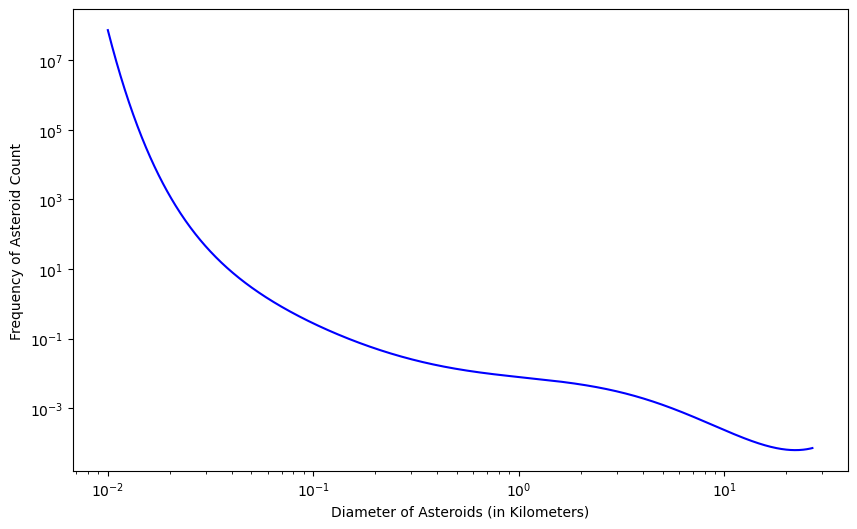

In [4]:
# plot data of diameter against asteroid count

import matplotlib.pyplot as plt


# create initial lists
bin_count = 1000
min_diameter = 0.01
max_diameeter = 27
diameter_list = np.logspace(np.log10(min_diameter), np.log10(max_diameeter), num=bin_count )
coefficient_list = [0,1.375, 0.1272, -1.2821, -0.3075, 0.4148, 0.1911, -0.04261, -3.1802e-3, 2.799e-3, 6.892e-4, 2.614e-6, -1.416e-6, -1.191e-6]

# get the list of relative plots
r_list = r_plot_prediction(diameter_list=diameter_list, coefficient_list=coefficient_list)
diff_diameter = np.diff(diameter_list)

diameter_list, r_list = diameter_list[:-1], r_list[:-1]

asteroid_count_list = r_list * diff_diameter * (diameter_list ** -3)

print(sum(asteroid_count_list))


# plot diameter against asteroid count list
plt.figure(figsize=(10, 6))
plt.loglog(diameter_list, asteroid_count_list, label='Asteroid Count Prediction', color='blue')
plt.xlabel("Diameter of Asteroids (in Kilometers)")
plt.ylabel("Frequency of Asteroid Count")

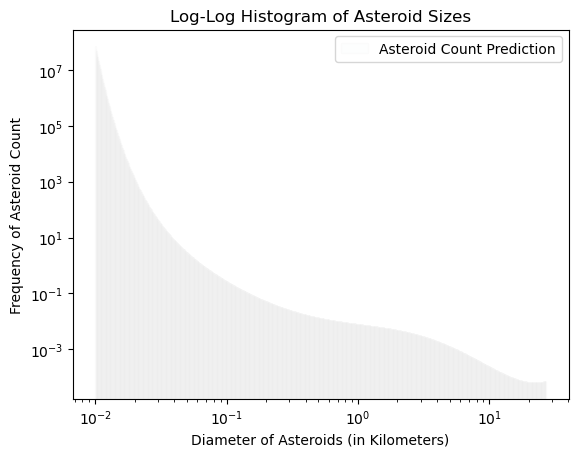

In [5]:

plt.bar(diameter_list, asteroid_count_list, width=np.diff(np.append(diameter_list, diameter_list[-1]*1.01)), 
        align='edge', edgecolor='k', color='skyblue', alpha=0.01, label='Asteroid Count Prediction')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Diameter of Asteroids (in Kilometers)")
plt.ylabel("Frequency of Asteroid Count")
plt.title("Log-Log Histogram of Asteroid Sizes")
plt.legend()
plt.show()

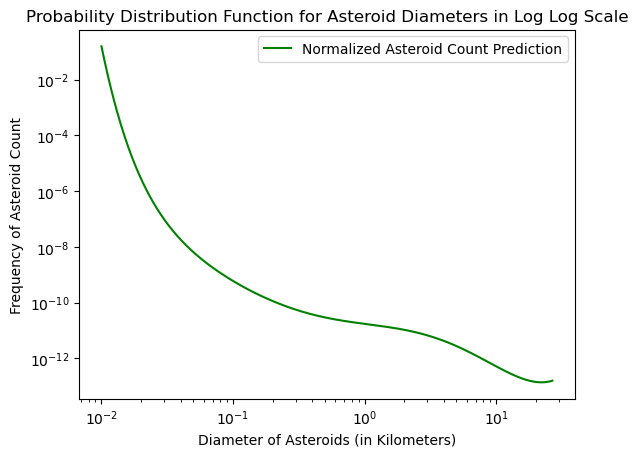

0.1587052205490762

In [6]:
normalized_asteroid_count_list = asteroid_count_list / sum(asteroid_count_list)

from matplotlib import pyplot as plt
# plt.bar(diameter_list, normalized_asteroid_count_list, width=np.diff(np.append(diameter_list, diameter_list[-1]*1.01)), 
#         align='edge', edgecolor='k', color='skyblue', alpha=0.01, label='Asteroid Count Prediction')
plt.plot(diameter_list, normalized_asteroid_count_list, label='Normalized Asteroid Count Prediction', color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Diameter of Asteroids (in Kilometers)")
plt.ylabel("Frequency of Asteroid Count")
plt.title("Probability Distribution Function for Asteroid Diameters in Log Log Scale")
plt.legend()
plt.show()

max(normalized_asteroid_count_list)

(array([1.546e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([1413716.69411541, 1414475.03804486, 1415233.38197431, ...,
        8995639.30077462, 8996397.64470408, 8997155.98863353]),
 <BarContainer object of 10000 artists>)

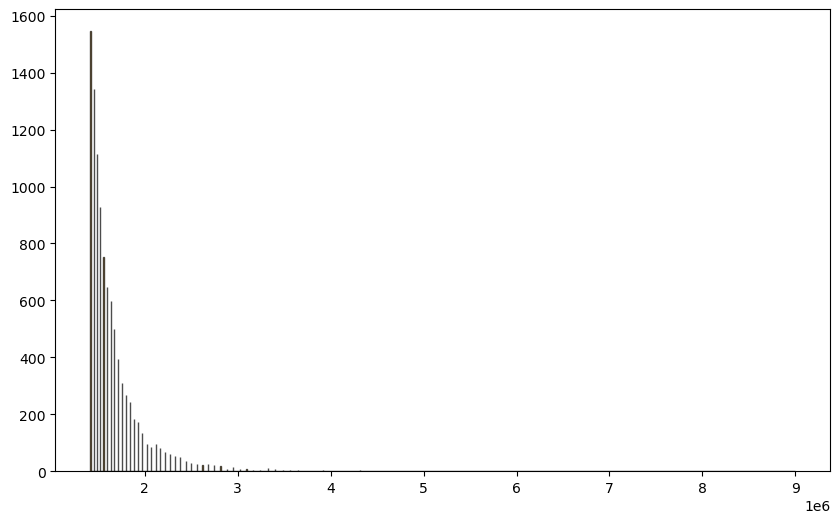

In [7]:
simulated_asteroid_diameters = generate_asteroid_population(diameter_list=diameter_list, normalized_asteroid_list=normalized_asteroid_count_list, k = 10000)
simulated_asteroid_volumes = calculate_volume(simulated_asteroid_diameters)
simulated_asteroid_masses = calculate_mass(simulated_asteroid_volumes)
# # create a plot of the histogram of the simulated asteroid diameters
plt.figure(figsize=(10, 6))
plt.hist(simulated_asteroid_masses, bins=10000, edgecolor='k', color='orange', alpha=0.7)

In [8]:
total_mass_list, total_diameter_list, total_volume_list = monte_carlo_simulation(diameter_list, normalized_asteroid_count_list, runs = 100, k = 1000000)

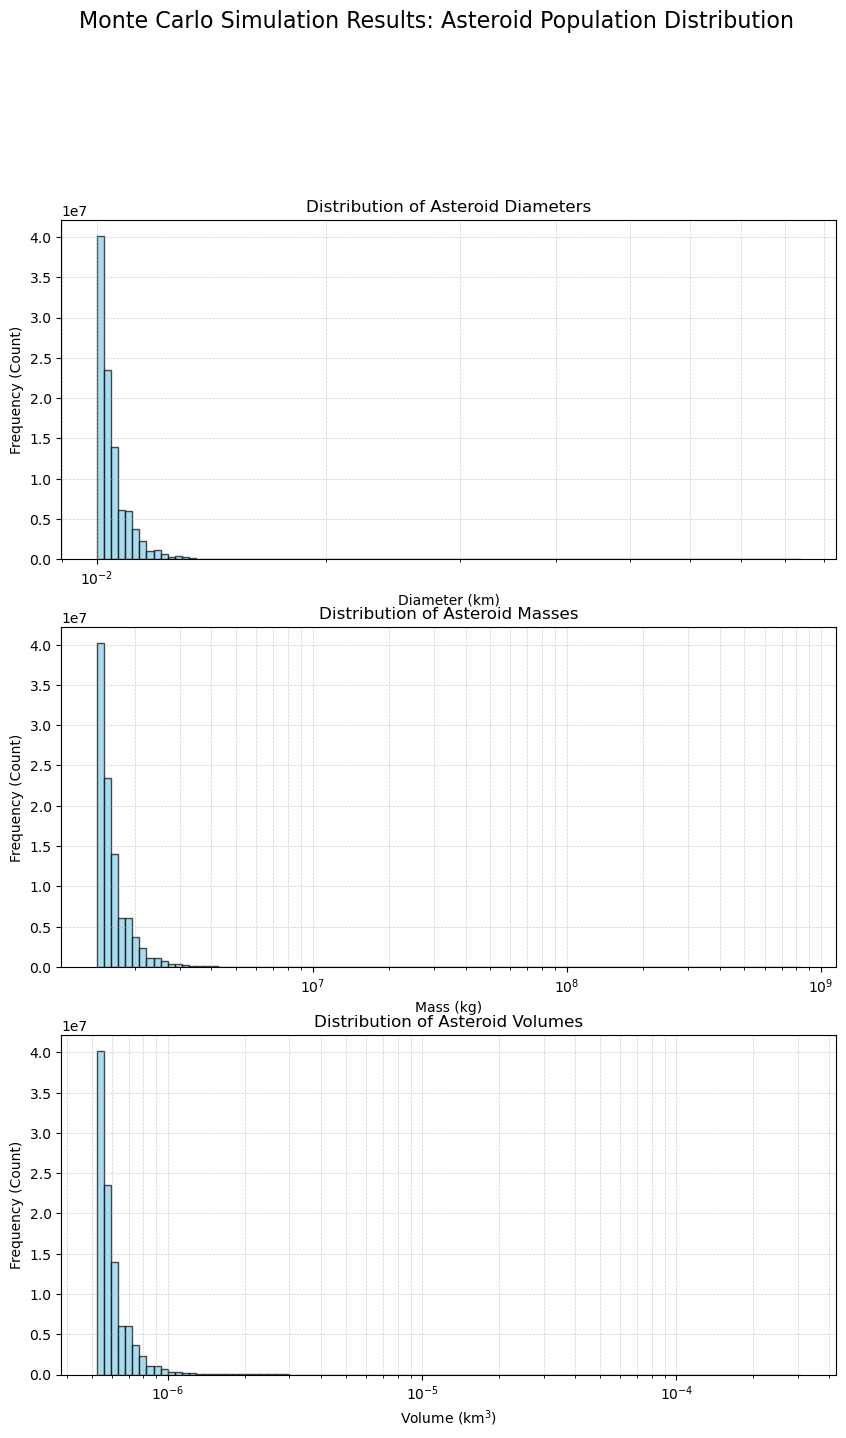

In [9]:
total_diameter_list = np.array(total_diameter_list)
total_mass_list = np.array(total_mass_list)
total_volume_list = np.array(total_volume_list)

fig, axes = plt.subplots(3, 1, figsize=(10, 15))
plt.suptitle('Monte Carlo Simulation Results: Asteroid Population Distribution', 
             fontsize=16, y=1.02)

create_log_histogram(
    total_diameter_list, 
    'Distribution of Asteroid Diameters', 
    'Diameter (km)', 
    axes[0]
)

# 2. Mass Histogram
create_log_histogram(
    total_mass_list, 
    'Distribution of Asteroid Masses', 
    'Mass (kg)', 
    axes[1]
)

# 3. Volume Histogram
create_log_histogram(
    total_volume_list, 
    'Distribution of Asteroid Volumes', 
    'Volume ($\mathrm{km}^3$)', 
    axes[2]
)

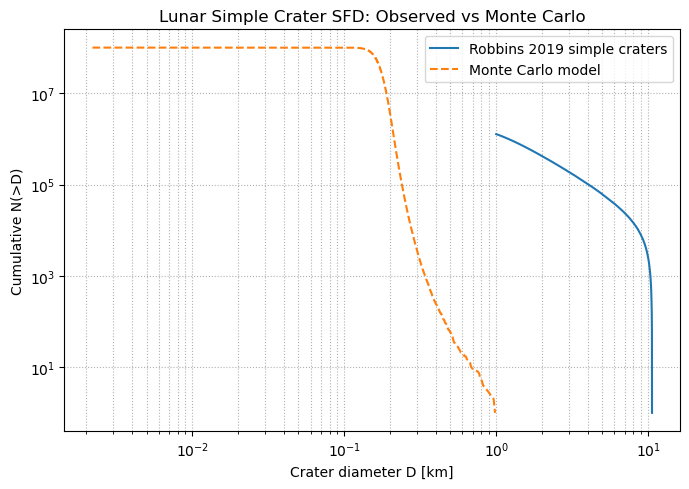

In [19]:
catalog = load_crater_catalog("lunar_crater_database_robbins_2018.csv")
simple_catalog = get_simple_craters(catalog)
results = monte_carlo_crater_population(n_runs=N_MONTE_CARLO,simple_craters=simple_catalog, mass_population = np.concatenate(total_mass_list, axis=0), random_state=42,)
D_obs_m = simple_catalog["D_final_m"].to_numpy()
D_sim_m = results["crater_diameters_m"]
plot_sfd_overlay(D_obs_m, D_sim_m)
# print("First 10 simulated crater diameters [m]:")
# print(D_sim_m[:10])

In [ ]:
len(np.concatenate(total_mass_list, axis=0))
10000000
100,000,000

100000000